In [2]:
import geopandas as gpd
import pandas as pd
from glob import glob
import pickle
import numpy as np
import sys
sys.path += ["../src"]

In [3]:
import utils
import jl_vae

geo_dict = jl_vae.load_geo_data()            

In [4]:
def get_cap_from_xy(df, geo_dict):
    df_geo = gpd.points_from_xy(df['x'], df['y'], z=None, crs="EPSG:4326")
    df_geo = df_geo.to_crs('EPSG:3035') #4326 3035
    if "CAP" in df.columns:
        df_ = df.drop(columns = ["CAP"]).copy()
    else:
        df_ = df.copy()
    df_gpd = gpd.GeoDataFrame(df_, geometry= df_geo)
    
    df_join = (gpd.tools.sjoin(df_gpd, geo_dict["cap"], 
                             predicate="within", how='left'))
    CAP = df_join["CAP"]
    
    return CAP.groupby(CAP.index).first()


In [4]:
from jl_synthetic_ipf_all_provinces import *

In [5]:
prov = "TS"
file = f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_{prov}.pickle'

with open(file, 'rb') as f:
    data = pickle.load(f)


In [6]:
"""def proportion_obs_houses(data, geo_dict):
    df_real = data["df_real"].copy()
    bins_mq = pd.qcut(df_real["log_mq"], q = 5, labels = False, duplicates = "drop", retbins = True)[1]
    bins_price = pd.qcut(df_real["log_price"], q = 5, labels = False, duplicates = "drop", retbins = True)[1]
    bins_mq[0] = -np.inf
    bins_mq[-1] = np.inf
    bins_price[0] = -np.inf
    bins_price[-1] = np.inf

    data_bins = {}
    for k in data:
        df_ = data[k].copy()
        df_["bin_mq"] = pd.cut(df_["log_mq"], bins = bins_mq)
        df_["bin_price"] = pd.cut(df_["log_price"], bins = bins_price)
        cap = get_cap_from_xy(df_, geo_dict)

        df_["CAP"] = cap
        df_.drop(columns = ["x", "y", "log_price", "log_mq"], inplace = True)
        data_bins[k] = df_
    
    drop_cols = []
    df_real_list = [list(u) for _,u in data_bins["df_real"].drop(columns = drop_cols).iterrows()]
    in_real = {k: np.mean([list(data_bins[k].drop(columns = drop_cols).iloc[u,:]) in df_real_list for u in range(len(data_bins[k]))]) for k in data_bins}
    return in_real"""

def proportion_obs_houses(data, geo_dict):
    df_real = data["df_real"].copy()
    bins_mq = pd.qcut(df_real["log_mq"], q = 5, labels = False, duplicates = "drop", retbins = True)[1]
    bins_price = pd.qcut(df_real["log_price"], q = 5, labels = False, duplicates = "drop", retbins = True)[1]
    bins_mq[0] = -np.inf
    bins_mq[-1] = np.inf
    bins_price[0] = -np.inf
    bins_price[-1] = np.inf
        

    data_bins = {}
    for k in list(data):
        df_ = data[k][df_real.columns].copy() + 0.
        df_["bin_mq"] = pd.cut(df_["log_mq"], bins = bins_mq)
        df_["bin_price"] = pd.cut(df_["log_price"], bins = bins_price)
        cap = get_cap_from_xy(df_, geo_dict)

        df_["CAP"] = cap
        df_.drop(columns = ["x", "y", "log_price", "log_mq"], inplace = True)
        data_bins[k] = df_
    
    drop_cols = []
    #df_real_list = [list(u) for _,u in data_bins["df_real"].drop(columns = drop_cols).iterrows()]
    #in_real = {k: np.mean([list(data_bins[k].drop(columns = drop_cols).iloc[u,:]) in df_real_list for u in range(len(data_bins[k]))]) for k in data_bins}

    #in_real = {k: data_bins[k].merge(data_bins["df_real"], how = "outer", indicator = True)
    #           .query("_merge != 'right_only'")["_merge"]
    #           .value_counts(normalize = True).loc["both"]
    #           for k in data_bins}
    in_real = {k:data_bins[k].set_index(list(data_bins["df_real"])).index.isin(data_bins["df_real"].set_index(list(data_bins["df_real"])).index).mean() for k in data_bins}
    
    return in_real



In [7]:
prop_obs_prov = proportion_obs_houses(data, geo_dict)

In [ ]:
{k:prop_obs_prov[k] for k in prop_obs_prov if "95" not in k}

{'df_real95': 1.0,
 'df_nfvae95': 0.41435368754956386,
 'df_ablation95': 0.16494845360824742,
 'df_copula_nf95': 0.07811260904044409,
 'df_copula_ablation95': 0.06859635210150675,
 'df_shuffle_province_bins95': 0.08604282315622522,
 'df_shuffle_cap_bins95': 0.9833465503568596,
 'df_shuffle_province_num95': 0.12053925455987312,
 'df_shuffle_cap_num95': 1.0}

In [14]:
all_zero_cell = {}

for file in sorted(glob(f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_*.pickle')):
    prov = file.split(".")[-2].split("_")[-1]
    with open(file, 'rb') as f:
        data = pickle.load(f)
    data = {k: data[k] for k in data if "95" not in k}

    prop_obs_prov = proportion_obs_houses(data, geo_dict)
    all_zero_cell[prov] = prop_obs_prov
    zero_cell_df = pd.DataFrame(all_zero_cell)
    zero_cell_df.to_csv(f'/data/housing/data/intermediate/jl_pop_synth/zero_cell_ips.csv')



In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots as sbp

<Axes: xlabel='prop_existing', ylabel='method'>

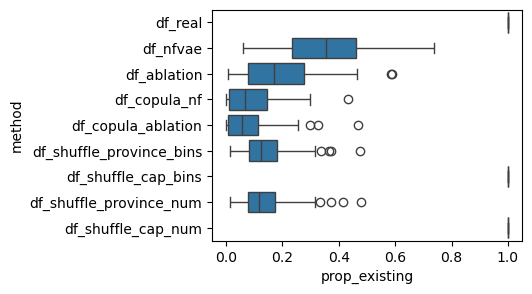

In [24]:
fig, axes = sbp(figsize = (4,3))

sns.boxplot(data = zero_cell_df.stack().reset_index().rename(columns = {"level_0": "method", "level_1": "prov", 0: "prop_existing"}),
            x = "prop_existing", y = "method")

### Generalization

In [16]:
def proportion_guessed_houses(data, geo_dict):
    df_real = data["df_real"].copy()
    bins_mq = pd.qcut(df_real["log_mq"], q = 5, labels = False, duplicates = "drop", retbins = True)[1]
    bins_price = pd.qcut(df_real["log_price"], q = 5, labels = False, duplicates = "drop", retbins = True)[1]
    bins_mq[0] = -np.inf
    bins_mq[-1] = np.inf
    bins_price[0] = -np.inf
    bins_price[-1] = np.inf
    
    data["df_holdout"] = data["df_real"].loc[~data["df_real"].index.isin(data["df_real95"].index)]

    data_bins = {}
    for k in list(data):
        df_ = data[k][df_real.columns].copy() + 0.
        df_["bin_mq"] = pd.cut(df_["log_mq"], bins = bins_mq)
        df_["bin_price"] = pd.cut(df_["log_price"], bins = bins_price)
        cap = get_cap_from_xy(df_, geo_dict)

        df_["CAP"] = cap
        df_.drop(columns = ["x", "y", "log_price", "log_mq"], inplace = True)
        data_bins[k] = df_
    
    drop_cols = []
    #df_real_list = [list(u) for _,u in data_bins["df_real"].drop(columns = drop_cols).iterrows()]
    #in_real = {k: np.mean([list(data_bins[k].drop(columns = drop_cols).iloc[u,:]) in df_real_list for u in range(len(data_bins[k]))]) for k in data_bins}

    #in_real = {k: data_bins[k].merge(data_bins["df_real"], how = "outer", indicator = True)
    #           .query("_merge != 'right_only'")["_merge"]
    #           .value_counts(normalize = True).loc["both"]
    #           for k in data_bins}
    in_real = {k:data_bins["df_holdout"].set_index(list(data_bins["df_real"])).index.isin(data_bins[k].set_index(list(data_bins["df_real"])).index).mean() for k in data_bins if "95" in k}
    
    return in_real


In [17]:
guessed_houses = {}

for file in sorted(glob(f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_*.pickle')):
    prov = file.split(".")[-2].split("_")[-1]
    with open(file, 'rb') as f:
        data = pickle.load(f)
    #data = {k: data[k] for k in data if "95" not in k}

    prop_guess_prov = proportion_guessed_houses(data, geo_dict)
    guessed_houses[prov] = prop_guess_prov
    #zero_cell_df = pd.DataFrame(all_zero_cell)
    #zero_cell_df.to_csv(f'/data/housing/data/intermediate/jl_pop_synth/zero_cell_ips.csv')



In [18]:
guessed_houses_df = pd.DataFrame(guessed_houses)

<Axes: xlabel='prop_existing', ylabel='method'>

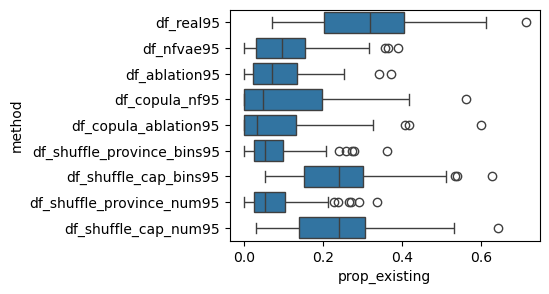

In [19]:
fig, axes = sbp(figsize = (4,3))

sns.boxplot(data = guessed_houses_df.stack().reset_index().rename(columns = {"level_0": "method", "level_1": "prov", 0: "prop_existing"}),
            x = "prop_existing", y = "method")

In [4]:
for file in sorted(glob(f'/data/housing/data/intermediate/jl_pop_synth/isp_baselines/all_baselines_TO.pickle')):
    prov = file.split(".")[-2].split("_")[-1]
    with open(file, 'rb') as f:
        data = pickle.load(f)


In [5]:
from sklearn.metrics import pairwise_distances
import gower


In [7]:
df1, df2 = data["df_real"].head(),data["df_nfvae"].head()
df = pd.concat([df1, df2
                ])


In [10]:
(df1 - df.min()) / (df.max()-df.min()+0.0001)

,flag_garage,flag_pertinenza,flag_air_conditioning,flag_multi_floor,y,x,log_mq,ANNO_COSTRUZIONE_1500_1965,ANNO_COSTRUZIONE_1965_1985,ANNO_COSTRUZIONE_1985_2005,...,COD_CAT_A_04_05,floor_0.0,floor_1.0,floor_2.0,floor_3.0,floor_Missing,floor_plus_4,log_price,flag_air_conditioning_Missing,flag_multi_floor_Missing
0,0.9999,0.0,0.0,0.0,0.359745,0.999874,0.231248,0.0,0.0,0.9999,...,0.0,0.0,0.9999,0.0,0.0,0.0,0.0,0.677688,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.655626,0.850167,0.0,0.9999,0.0,...,0.9999,0.0,0.0,0.0,0.0,0.9999,0.0,0.726991,0.9999,0.9999
2,0.0,0.0,0.0,0.0,0.613337,0.957157,0.299789,0.9999,0.0,0.0,...,0.0,0.0,0.0,0.0,0.9999,0.0,0.0,0.53295,0.0,0.0
3,0.0,0.0,0.0,0.0,0.929834,0.254841,0.999925,0.9999,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.9999,0.0,0.422588,0.9999,0.9999
4,0.0,0.0,0.0,0.0,0.379404,0.717189,0.194487,0.0,0.9999,0.0,...,0.0,0.0,0.9999,0.0,0.0,0.0,0.0,0.532886,0.0,0.0


In [17]:
gower.gower_matrix(np.array((df1 - df.min()) / (df.max()-df.min()+0.0001)), np.array((df2 - df.min()) / (df.max()-df.min()+0.0001)))

array([[0.3931528 , 0.45272985, 0.4276175 , 0.17470203, 0.34070864],
       [0.45272985, 0.22090358, 0.20285684, 0.27633524, 0.40785852],
       [0.4276175 , 0.20285684, 0.30659494, 0.21350808, 0.23972194],
       [0.17470203, 0.27633524, 0.21350808, 0.37646157, 0.28348744],
       [0.34070864, 0.40785852, 0.23972194, 0.28348744, 0.29437953]],
      dtype=float32)

In [18]:
pairwise_distances(np.array((df1 - df.min()) / (df.max()-df.min()+0.0001)), np.array((df2 - df.min()) / (df.max()-df.min()+0.0001)), metric = "euclidean")


array([[3.32307639, 3.54396432, 3.4090247 , 2.09259897, 3.04334103],
       [2.18145725, 2.34512945, 2.29586287, 2.70426443, 3.33133806],
       [2.84011397, 3.03591726, 2.87120554, 2.33257975, 2.49690408],
       [1.15876212, 0.81659641, 0.76870565, 3.15831851, 2.75583973],
       [3.16719087, 3.30244414, 3.24872578, 1.87332872, 2.84763841]])

In [27]:
pd.concat([((df1 - df.mean()) / (df.std()+0.0001)).iloc[2], ((df1 - df.mean()) / (df.std()+0.0001)).iloc[1]], axis = 1)

,2,1
flag_garage,-0.474229,-0.474229
flag_pertinenza,0.0,0.0
flag_air_conditioning,0.0,0.0
flag_multi_floor,0.0,0.0
y,0.327859,-1.785747
x,0.833771,-0.110241
log_mq,-0.430215,1.240864
ANNO_COSTRUZIONE_1500_1965,0.774447,-1.16167
ANNO_COSTRUZIONE_1965_1985,-0.62093,1.448838
ANNO_COSTRUZIONE_1985_2005,-0.316128,-0.316128
